In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as const

from os import walk
import photutils

from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats

from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import CircularAnnulus
from photutils import psf

In [2]:
def setupFits(file):
    with fits.open(file) as f:
        #f.info()
        hdu = f[0]
        head = hdu.header
        data = hdu.data
    return head, data

In [3]:
bias_files = []
bias = 0
for (dirpath, dirnames, filenames) in walk('./Wolf1346/'):
    bias_files.extend(filenames)
    
    break

    
bias_files= [ x for x in bias_files if "bias"  in x ]
bias_files = ['./Wolf1346/' + s for s in bias_files]

means = []

for i in bias_files:
    head, data = setupFits(i)
    bias = bias + data
    means.append(np.mean(data))
    
master_bias = bias / len(bias_files)

f_head, f_data = setupFits('Wolf1346/wolf1346_.0001.fits')
f_data = f_data - master_bias 

f_data[f_data < 0] = max(f_data.flatten())

mean, median, std = sigma_clipped_stats(f_data, sigma=3.0) 
print(np.shape(f_data), np.shape(master_bias))

f_data = np.delete(f_data,np.s_[1026:1076], axis=1)
f_data = np.delete(f_data,np.s_[1024:1026], axis=0)

master_bias = np.delete(master_bias,np.s_[1026:1076], axis=1)
master_bias = np.delete(master_bias,np.s_[1024:1026], axis=0)
print(np.shape(f_data), np.shape(master_bias))

(2050, 2102) (2050, 2102)
(2048, 2052) (2048, 2052)


In [4]:



#plt.figure();
#plt.imshow(f_data, cmap='gray', vmin=0, vmax = 1000);
#plt.colorbar();

380


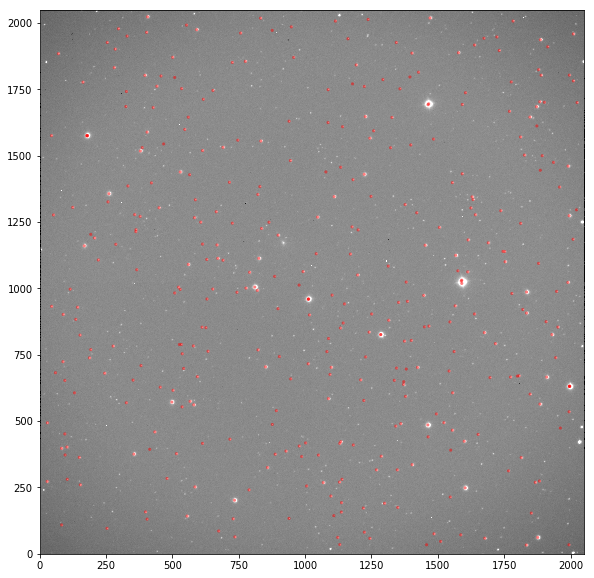

In [5]:
daofind = DAOStarFinder(fwhm=3.0, threshold=10*std)    
sources = daofind(f_data)  

mask = ((sources['xcentroid'] <2025) & (sources['ycentroid'] > 25) & (sources['xcentroid'] > 25) & (sources['ycentroid'] < 2025))

sources=sources[mask]

plt.figure(figsize=(10,10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=3.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(f_data, 
           cmap=plt.cm.gray, 
           origin='lower', norm=norm,  vmin=0, vmax=1000);
apertures.plot(color='red', lw=1.5, alpha=0.5);
print(len(sources))

In [6]:
phot_table_ex = aperture_photometry(data, apertures,method='exact')
phot_table_ex['aperture_sum'].info.format = '%.8g'  # for consistent table output


phot_table_sub = aperture_photometry(data, apertures,method='subpixel', subpixels=5)
phot_table_sub['aperture_sum'].info.format = '%.8g'  # for consistent table output

phot_table_cen = aperture_photometry(data, apertures,method='center')
phot_table_cen['aperture_sum'].info.format = '%.8g'  # for consistent table output


print(np.mean(phot_table_cen['aperture_sum'] / phot_table_ex['aperture_sum']))

print(np.mean(phot_table_cen['aperture_sum'] / phot_table_sub['aperture_sum']))

print(np.mean(phot_table_sub['aperture_sum'] / phot_table_ex['aperture_sum']))





#sources.sort(['peak'])
#sources

0.9972978022533318
0.9970181139609254
1.0002708433873169


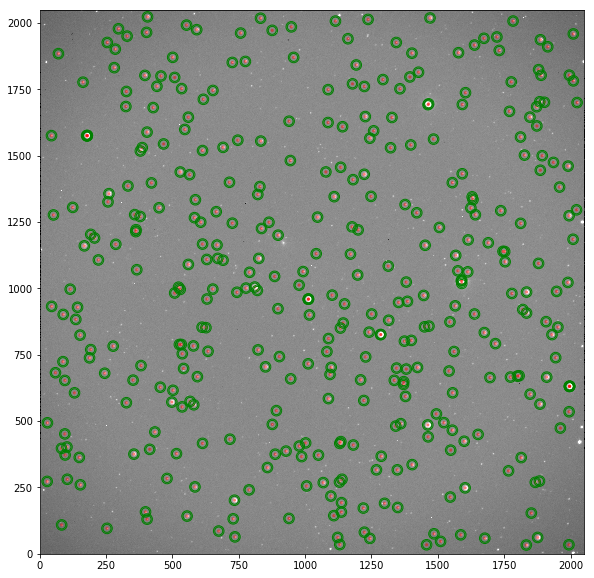

In [7]:
def merge(list1, list2): 
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
    return merged_list 

#cuts off edge stars


source_pos = merge(sources['xcentroid'], sources['ycentroid'])

aper_rad = 3
aper_area = np.pi * aper_rad**2
ann_in = 15
ann_out = 20
ann_area = np.pi * (ann_out**2 - ann_in**2)

annuli = CircularAnnulus(source_pos, ann_in, ann_out)


plt.figure(figsize=(10,10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=aper_rad)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(f_data, 
           cmap=plt.cm.gray, 
           origin='lower', norm=norm,  vmin=0, vmax=1000);
apertures.plot(color='red', lw=1.5, alpha=0.5);
annuli.plot(color='green')

In [8]:
annul_table_sub = aperture_photometry(data, annuli)
annul_table_sub['aperture_sum'].info.format = '%.8g'  # for consistent table output

annul_table_sub['annulus_average'] = annul_table_sub['aperture_sum'] / ann_area
phot_table_sub['sum-sky'] = phot_table_ex['aperture_sum'] - aper_area*annul_table_sub['annulus_average']
phot_table_sub.sort('id')
phot_table_sub

id,xcenter,ycenter,aperture_sum,sum-sky
,pix,pix,,
int64,float64,float64,float64,float64
1,1833.2881432892395,32.55356772458595,10219.04,-8.7509735
2,1993.898623396073,33.46758408826596,10238.72,-16.484226
3,1130.6006246264176,34.25988354566992,10091.68,2.2667032
4,1457.5698173500343,33.52083246530607,10183.24,9.6351509
5,1510.4599233367737,46.27763871666195,10190.72,0.36688972
6,1243.931990943999,57.50685224876446,10182.24,8.4421814
7,1676.9612323820727,58.15763652650606,10181.72,12.631798
8,1122.6229173447323,61.26916552537855,10147.08,-3.2643392


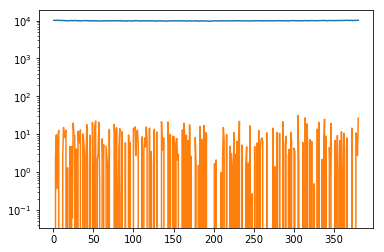

In [9]:
plt.plot(phot_table_sub['id'], phot_table_sub['aperture_sum'])
plt.plot(phot_table_sub['id'], phot_table_sub['sum-sky'])
plt.yscale('log')

In [10]:
flat_files = []
for (dirpath, dirnames, filenames) in walk('./Wolf1346/'):
    flat_files.extend(filenames)
    
    break
    
flat_files.sort()

    
flat_files= [ x for x in flat_files if "flat"  in x ]
flat_files = ['./Wolf1346/' + s for s in flat_files]

filters = [None] * len(flat_files)
for i in range(len(flat_files)):
    head, data = setupFits(flat_files[i])
    filters[i] = head['FILTER']
    
#for i in range(len(flat_files)):
    #print(flat_files[i], filters[i])

In [11]:
annul_table_sub

id,xcenter,ycenter,aperture_sum,annulus_average
,pix,pix,,
int64,float64,float64,float64,float64
1,1833.2881432892395,32.55356772458595,198272.79,360.64108
2,1993.898623396073,33.46758408826596,199084.57,362.11765
3,1130.6006246264176,34.25988354566992,197817.55,359.81305
4,1457.5698173500343,33.52083246530607,197780.96,359.74648
5,1510.4599233367737,46.27763871666195,197545.06,359.31741
6,1243.931990943999,57.50685224876446,197228.92,358.74238
7,1676.9612323820727,58.15763652650606,197417.32,359.08505
8,1122.6229173447323,61.26916552537855,197332.74,358.93121


In [12]:
#annul_table_sub['aperture_sum'] /( ann_area * (650 - np.mean(master_bias)))

In [13]:
apers = [apertures, annuli]
phot_table = aperture_photometry(data, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1833.2881 32.553568      683386.74       13270277
  2 1993.8986 33.467584      608582.06       11846181
  3 1130.6006 34.259884      837186.72       16268024
  4 1457.5698 33.520832      799293.51       15537435
  5 1510.4599 46.277639      793914.07       15435017
  6  1243.932 57.506852      843021.29       16395573
  7 1676.9612 58.157637      754242.11       14648461
  8 1122.6229 61.269166      851094.78       16537773
  9 1876.0565 61.109735      681457.14       13245906
 10  735.5313 63.219694      806960.89       15688877
...       ...       ...            ...            ...
371 591.48792 1974.1032      862385.85       16754095
372 296.74181 1977.5161      775710.63       15064222
373 948.00102  1984.703      892952.55       17360576
374 553.16528 1991.3271       846579.7       16444610
375 1114.1817 2006.4704     

In [14]:
annulus_masks = annuli.to_mask(method='center')

phot_table_sub['annulus_sum'] = None

for i in range(len(phot_table_sub)):
    phot_table_sub['annulus_sum'][i] = sum((annulus_masks[i].multiply(f_data)).flatten())
    #x = annulus_masks[i].multiply(f_data)
    #print(np.shape(x), sum(x.flatten()))
    
    
phot_table_sub

id,xcenter,ycenter,aperture_sum,sum-sky,annulus_sum
,pix,pix,,,
int64,float64,float64,float64,float64,object
1,1833.2881432892395,32.55356772458595,10219.04,-8.7509735,116523.90909090915
2,1993.898623396073,33.46758408826596,10238.72,-16.484226,101496.63636363624
3,1130.6006246264176,34.25988354566992,10091.68,2.2667032,149429.63636363632
4,1457.5698173500343,33.52083246530607,10183.24,9.6351509,138608.18181818174
5,1510.4599233367737,46.27763871666195,10190.72,0.36688972,136969.36363636373
6,1243.931990943999,57.50685224876446,10182.24,8.4421814,149409.4545454545
7,1676.9612323820727,58.15763652650606,10181.72,12.631798,131440.0909090909
8,1122.6229173447323,61.26916552537855,10147.08,-3.2643392,149523.09090909085


In [15]:
#annul_table_sub = aperture_photometry(data, annuli)
#annul_table_sub['aperture_sum'].info.format = '%.8g'  # for consistent table output

phot_table_sub['annulus_average'] = phot_table_sub['annulus_sum'] / ann_area
phot_table_sub['sum-sky'] = phot_table_sub['aperture_sum'] - aper_area*phot_table_sub['annulus_average']
phot_table_sub.sort('id')
phot_table_sub

id,xcenter,ycenter,aperture_sum,sum-sky,annulus_sum,annulus_average
,pix,pix,,,,
int64,float64,float64,float64,object,object,object
1,1833.2881432892395,32.55356772458595,10219.04,4226.3818,116523.90909090915,211.94692708810095
2,1993.898623396073,33.46758408826596,10238.72,5018.893,101496.63636363624,184.61361582255225
3,1130.6006246264176,34.25988354566992,10091.68,2406.7273,149429.63636363632,271.79960310511035
4,1457.5698173500343,33.52083246530607,10183.24,3054.8192,138608.18181818174,252.11631187821484
5,1510.4599233367737,46.27763871666195,10190.72,3146.5813,136969.36363636373,249.1354431414696
6,1243.931990943999,57.50685224876446,10182.24,2498.3252,149409.4545454545,271.76289412083355
7,1676.9612323820727,58.15763652650606,10181.72,3421.9439,131440.0909090909,239.0781735843419
8,1122.6229173447323,61.26916552537855,10147.08,2457.321,149523.09090909085,271.9695888521217


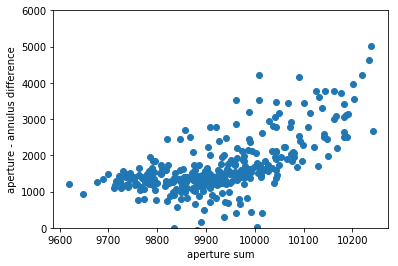

In [16]:
plt.scatter(phot_table_sub['aperture_sum'], phot_table_sub['sum-sky']);
#plt.plot(phot_table_sub['id'], phot_table_sub['sum-sky'])
plt.ylim(0, 6000);
plt.xlabel('aperture sum');
plt.ylabel('aperture - annulus difference');

In [17]:
#plt.plot(phot_table_sub['id'], phot_table_sub['aperture_sum']/phot_table_sub['sum-sky'])
#phot_table_sub.sort('sum-sky')
#phot_table_sub

In [18]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils import BasicPSFPhotometry
from astropy.table import Table

In [22]:
psf_sources = Table()
#psf_sources['id'] = (np.linspace(1,len(sources), len(sources))).astype(int)
psf_sources['id'] = phot_table_sub['id']
psf_sources['x_0'] = phot_table_sub['xcenter']
psf_sources['y_0'] = phot_table_sub['ycenter']
psf_sources


sigma_psf = 2.0
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
result_tab = photometry(image=f_data, init_guesses=psf_sources)
residual_image = photometry.get_residual_image()

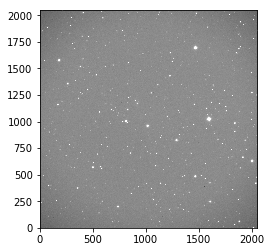

In [23]:
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(f_data, 
           cmap=plt.cm.gray, 
           origin='lower', norm=norm,  vmin=0, vmax=1000);

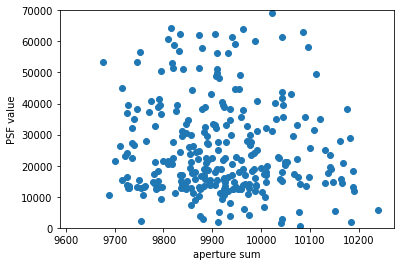

In [24]:
plt.scatter(phot_table_sub['aperture_sum'], result_tab['flux_fit']);
#plt.plot(phot_table_sub['id'], phot_table_sub['sum-sky'])
plt.ylim(0, 70000);
plt.xlabel('aperture sum');
plt.ylabel('PSF value');